# High pass frequency filtering

**Author: Uzhva Denis Romanovich**

**Lecturer: Soloviev Igor Pavlovich**

## Ideal, Butterworth, Gaussian, Laplacian filters and the amplification highpass filter
### Theory

High pass filtering is applied to increase sharp transitions on images.
In order to obtain a high-pass filter, one may subtract its low-pass version from 1.
Thus, we propose four filters (Ideal, Butterworth, Gaussian and Laplacian):
$$
\begin{equation}
    \begin{gathered}
        H(u, v) = 
        \begin{cases}
            0, \textrm{at } D(u, v) \leq D_0 \\
            1, \textrm{else};
        \end{cases} \\
        H(u, v) = \frac{(D(u, v) / D_0)^{2n}}{1 + (D(u, v) / D_0)^{2n}}; \\
        H(u, v) = 1 - \exp (-D^2(u, v) / 2 D_0); \\
        H(u, v) = -4 \pi^2 D^2(u, v);
    \end{gathered}
\end{equation}
$$
where $D(u, v)$ is the distance from a center of an image and $D_0$ is a constant.

We define the amplification high-pass filter as follows:
$$
\begin{equation}
    g(x, y) = \mathfrak{F}^{-1} \{[ k_1 + k_2 H_\textrm{HP}(u, v) ]F(u, v) \},
\end{equation}
$$
where the constant $k_1$ is the overall brightness and $k_2$ stands for the contribution of the filter.

### Code

#### Fast fourier transform

In [1]:
import numpy as np


def get_fft(img, shift=False):
    h = img.shape[0]
    w = img.shape[1]
    img = img.astype(np.complex)
    
    x_arr = np.arange(h)
    y_arr = np.arange(w)
    
    x_mat = np.repeat(x_arr.reshape((h, 1)), w, 1)
    y_mat = np.repeat(y_arr.reshape((1, w)), h, 0)
    
    if shift:
        exp_val = (x_mat + y_mat) * np.pi * 1j
        img = np.multiply(img, np.exp(exp_val))
        
    if len(img.shape) == 3:
        img = np.swapaxes(img, 0, 2)
        img_fft = np.fft.fft2(img)
    else:
        img_fft = np.fft.fft2(img)
        
    return img_fft

#### Inverse FFT

In [2]:
import numpy as np


def get_ifft(img_fft, shift=False):
    h = img_fft.shape[0]
    w = img_fft.shape[1]
    img_fft = img_fft.astype(np.complex)
    
    u_arr = np.arange(h)
    v_arr = np.arange(w)
    
    u_mat = np.repeat(u_arr.reshape((h, 1)), w, 1)
    v_mat = np.repeat(v_arr.reshape((1, w)), h, 0)
     
    if shift:
        exp_val = (u_mat + v_mat) * np.pi * 1j
        img_fft = np.multiply(img_fft, np.exp(exp_val))
        
    if len(img_fft.shape) == 3:
        img_fft = np.swapaxes(img_fft, 0, 2)
        img_ifft = np.fft.ifft2(img_fft)
    else:
        img_ifft = np.fft.ifft2(img_fft)
        
    return img_ifft

#### Ideal high pass filter

In [51]:
import numpy as np


def apply_ideal_HP(img_fft, d0perc=.5):
    h = img_fft.shape[0]
    w = img_fft.shape[1]
    
    d0 = d0perc * np.min([h, w]) / 2
    
    u_arr = np.arange(h)
    v_arr = np.arange(w)
    
    u_mat = np.repeat(u_arr.reshape((h, 1)), w, 1)
    v_mat = np.repeat(v_arr.reshape((1, w)), h, 0)
    
    dist_mat = np.sqrt(np.power((u_mat - h//2), 2) + np.power((v_mat - w//2), 2))
    
    filter_mat = np.zeros_like(dist_mat)
    filter_mat[dist_mat > d0] = 1.
    
    if len(img_fft.shape) == 3:
        channels = img_fft.shape[-1]
        for ch in range(channels):
            img_fft[:, :, ch] = np.multiply(img_fft[:, :, ch], filter_mat)
    else:
        img_fft = np.multiply(img_fft, filter_mat)
        
    return img_fft, filter_mat

#### Butterworth high pass filter

In [55]:
import numpy as np


def apply_bw_HP(img_fft, d0perc=.5, n=1):
    h = img_fft.shape[0]
    w = img_fft.shape[1]
    
    d0 = d0perc * np.min([h, w]) / 2
    
    u_arr = np.arange(h)
    v_arr = np.arange(w)
    
    u_mat = np.repeat(u_arr.reshape((h, 1)), w, 1)
    v_mat = np.repeat(v_arr.reshape((1, w)), h, 0)
    
    dist_mat = np.sqrt(np.power((u_mat - h//2), 2) + np.power((v_mat - w//2), 2))
    
    filter_mat = np.full_like(dist_mat, 1.) - 1 / (1 + np.power((dist_mat / d0), 2*n))
    
    if len(img_fft.shape) == 3:
        channels = img_fft.shape[-1]
        for ch in range(channels):
            img_fft[:, :, ch] = np.multiply(img_fft[:, :, ch], filter_mat)
    else:
        img_fft = np.multiply(img_fft, filter_mat)
        
    return img_fft, filter_mat

#### Gaussian high pass filter

In [53]:
import numpy as np


def apply_gauss_HP(img_fft, d0perc=.5):
    h = img_fft.shape[0]
    w = img_fft.shape[1]
    
    d0 = d0perc * np.min([h, w]) / 2
    
    u_arr = np.arange(h)
    v_arr = np.arange(w)
    
    u_mat = np.repeat(u_arr.reshape((h, 1)), w, 1)
    v_mat = np.repeat(v_arr.reshape((1, w)), h, 0)
    
    dist_mat = np.sqrt(np.power((u_mat - h//2), 2) + np.power((v_mat - w//2), 2))
    
    filter_mat = np.full_like(dist_mat, 1.) - np.exp(-np.power(dist_mat, 2) / (2 * d0 * d0))
    
    if len(img_fft.shape) == 3:
        channels = img_fft.shape[-1]
        for ch in range(channels):
            img_fft[:, :, ch] = np.multiply(img_fft[:, :, ch], filter_mat)
    else:
        img_fft = np.multiply(img_fft, filter_mat)
        
    return img_fft, filter_mat

#### Laplacian high pass filter

In [54]:
import numpy as np


def apply_laplac_HP(img_fft):
    h = img_fft.shape[0]
    w = img_fft.shape[1]
    
    u_arr = np.arange(h)
    v_arr = np.arange(w)
    
    u_mat = np.repeat(u_arr.reshape((h, 1)), w, 1)
    v_mat = np.repeat(v_arr.reshape((1, w)), h, 0)
    
    dist_mat = np.sqrt(np.power((u_mat - h//2), 2) + np.power((v_mat - w//2), 2))
    
    filter_mat = -4 * np.pi * np.pi * np.power(dist_mat, 2)
    
    if len(img_fft.shape) == 3:
        channels = img_fft.shape[-1]
        for ch in range(channels):
            img_fft[:, :, ch] = np.multiply(img_fft[:, :, ch], filter_mat)
    else:
        img_fft = np.multiply(img_fft, filter_mat)
        
    return img_fft, filter_mat

#### Amplification high pass filter

In [9]:
import numpy as np


def apply_amp_HP(img_fft, filter_mat, k1=1., k2=1.):
    img_fft = np.multiply((k1 + k2*filter_mat), img_fft)
    
    return img_fft

### Results

#### Processing + visualization

First of all, we need to load images for the further processing.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


img_1 = Image.open('./text1.jpg')
img_2 = Image.open('./text2.jpg')

In [13]:
# represent the images as tensors
np_1 = np.array(img_1)
np_2 = np.array(img_2)
print('Picture dimensions:')
print(np_1.shape)
print(np_2.shape)

Picture dimensions:
(256, 256, 3)
(256, 256, 3)


In [14]:
# simplify the images by summing the channels
np_1_sum = np.sum(np_1, axis=2) // 3
np_2_sum = np.sum(np_2, axis=2) // 3

Apply FFT to the images:

In [15]:
np_1_fft = get_fft(np_1_sum, True)
np_2_fft = get_fft(np_2_sum, True)

In [16]:
# log of abs

np_1_fft_logabs = np.log(np.abs(np_1_fft)+1)
np_2_fft_logabs = np.log(np.abs(np_2_fft)+1)

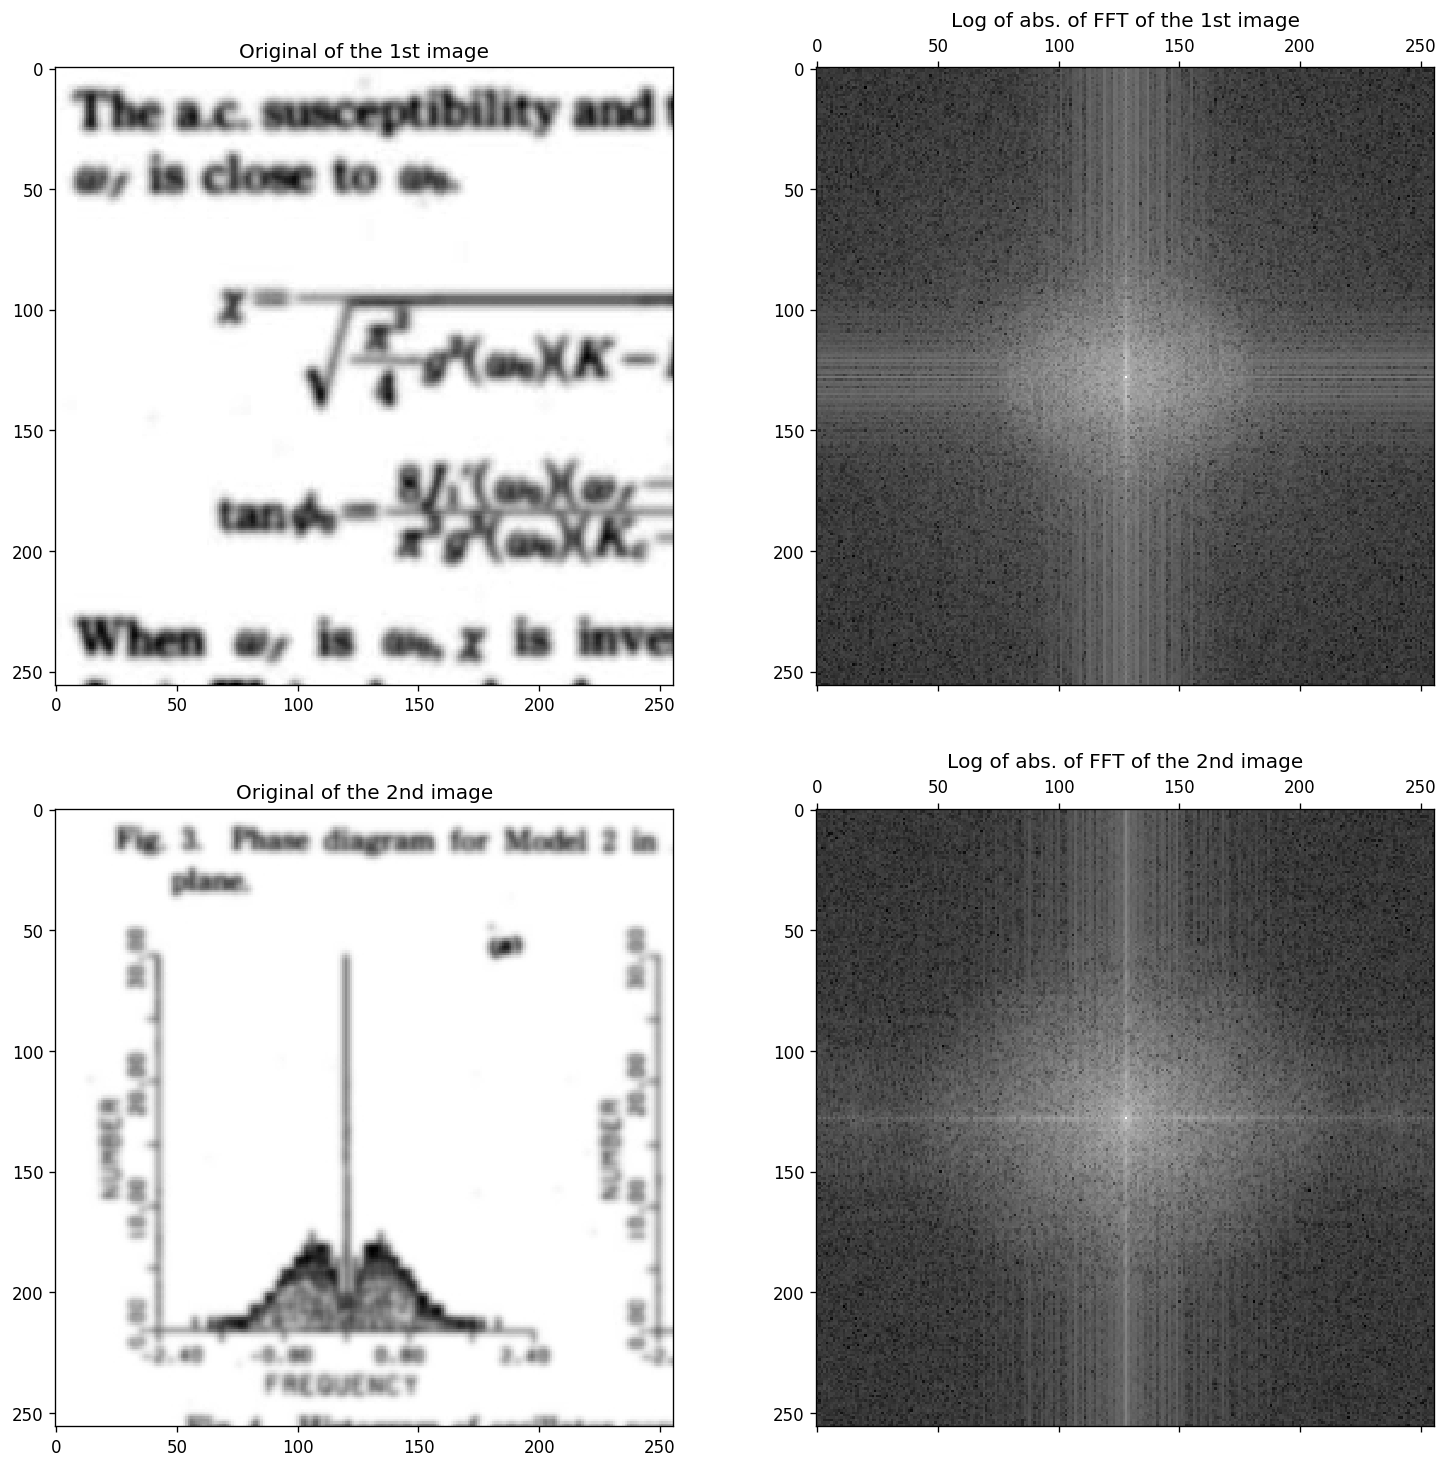

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15), dpi=120)
axs[0, 0].imshow(np_1_sum, cmap='gray')
axs[0, 0].set_title('Original of the 1st image')
axs[0, 1].matshow(np_1_fft_logabs, cmap='gray')
axs[0, 1].set_title('Log of abs. of FFT of the 1st image')
axs[1, 0].imshow(np_2_sum, cmap='gray')
axs[1, 0].set_title('Original of the 2nd image')
axs[1, 1].matshow(np_2_fft_logabs, cmap='gray')
axs[1, 1].set_title('Log of abs. of FFT of the 2nd image')
plt.show()

Apply the ideal filter with various $D_0$ (which we define as a percentage of image's height).

In [56]:
np_1_id1, _ = apply_ideal_HP(np_1_fft, .01)
np_1_id2, _ = apply_ideal_HP(np_1_fft, .05)
np_1_id3, _ = apply_ideal_HP(np_1_fft, .1)

np_1_id1i = np.abs(get_ifft(np_1_id1))
np_1_id2i = np.abs(get_ifft(np_1_id2))
np_1_id3i = np.abs(get_ifft(np_1_id3))

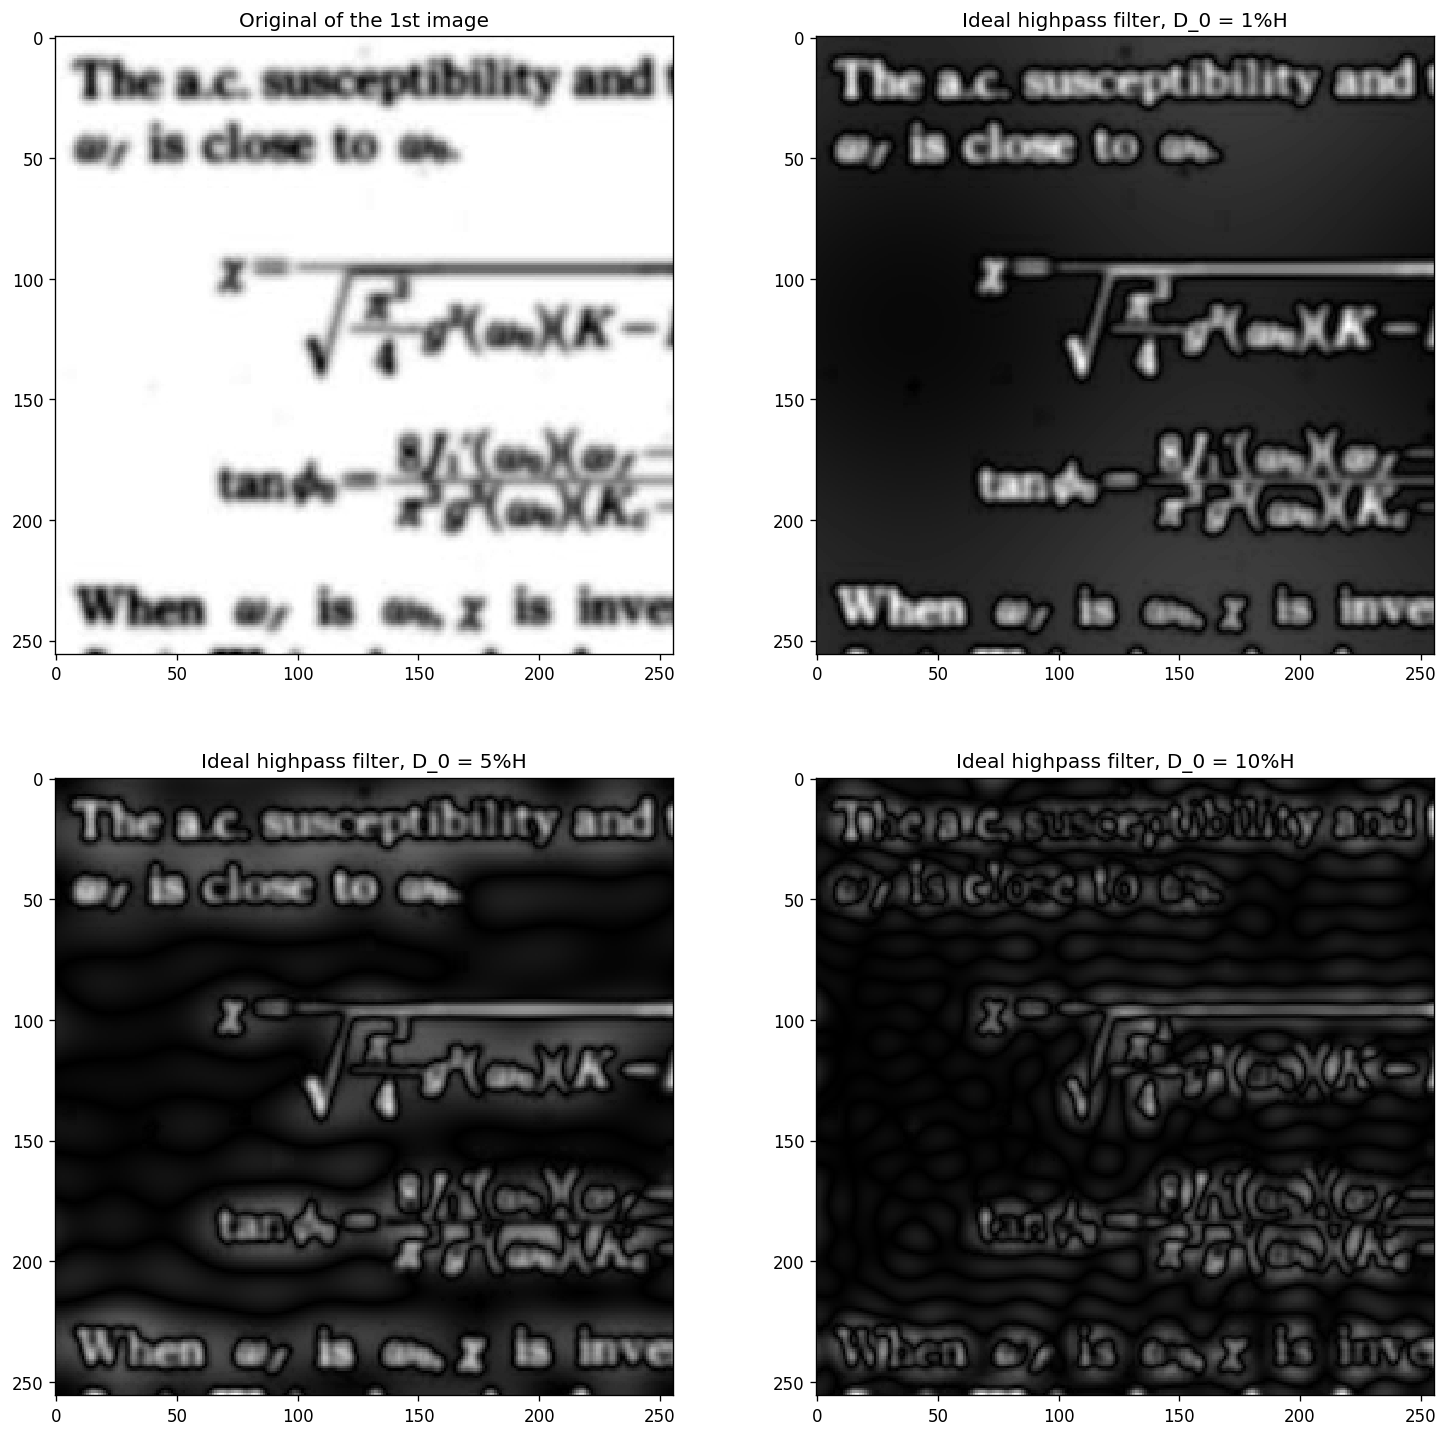

In [39]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15), dpi=120)
axs[0, 0].imshow(np_1_sum, cmap='gray')
axs[0, 0].set_title('Original of the 1st image')
axs[0, 1].imshow(np_1_id1i, cmap='gray')
axs[0, 1].set_title('Ideal highpass filter, D_0 = 1%H')
axs[1, 0].imshow(np_1_id2i, cmap='gray')
axs[1, 0].set_title('Ideal highpass filter, D_0 = 5%H')
axs[1, 1].imshow(np_1_id3i, cmap='gray')
axs[1, 1].set_title('Ideal highpass filter, D_0 = 10%H')
plt.show()

The best improvements can be seen at $D_0 \sim 5\%$.

Apply the Butterworth filter with various $D_0$ and $n$.

In [57]:
## order 2

np_1_bw1_2, _ = apply_bw_HP(np_1_fft, .01, 2)
np_1_bw2_2, _ = apply_bw_HP(np_1_fft, .05, 2)
np_1_bw3_2, _ = apply_bw_HP(np_1_fft, .10, 2)

np_1_bw1i_2 = np.abs(get_ifft(np_1_bw1_2))
np_1_bw2i_2 = np.abs(get_ifft(np_1_bw2_2))
np_1_bw3i_2 = np.abs(get_ifft(np_1_bw3_2))

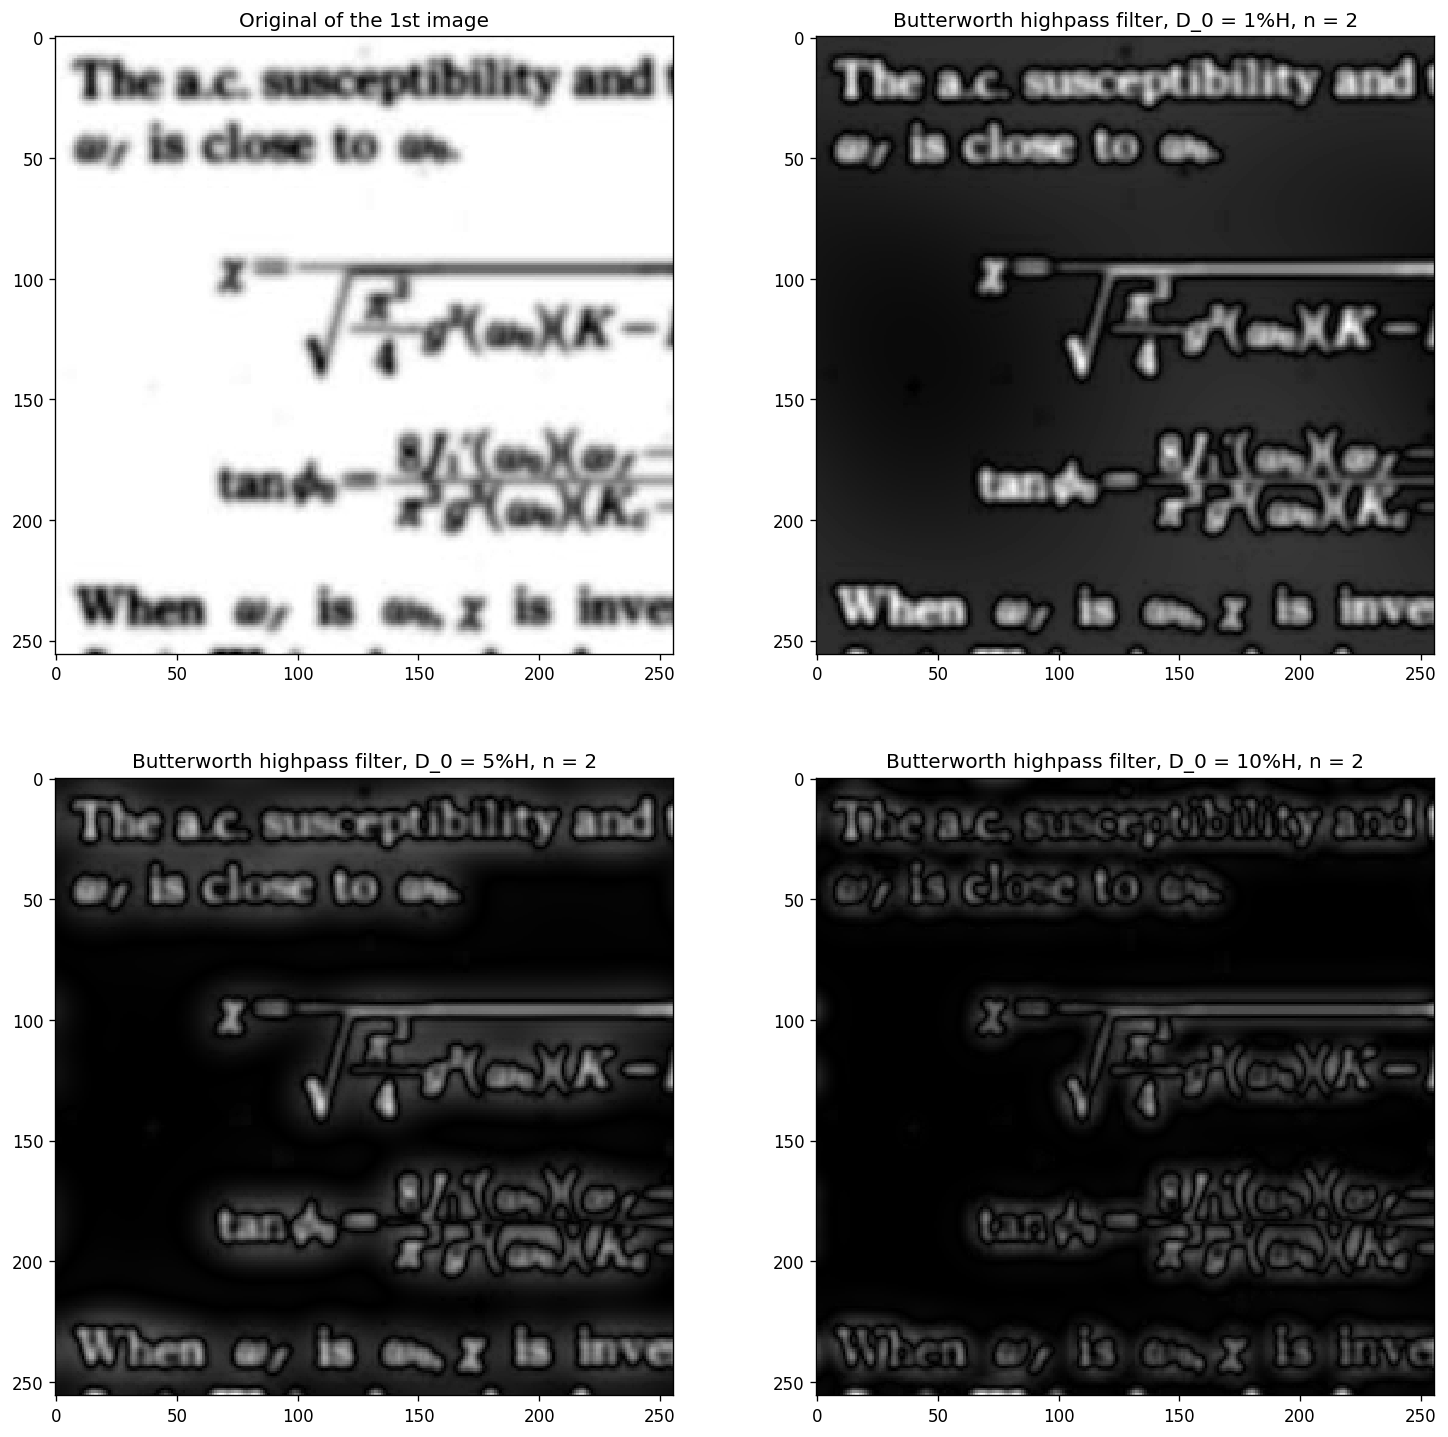

In [38]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15), dpi=120)
axs[0, 0].imshow(np_1_sum, cmap='gray')
axs[0, 0].set_title('Original of the 1st image')
axs[0, 1].imshow(np_1_bw1i_2, cmap='gray')
axs[0, 1].set_title('Butterworth highpass filter, D_0 = 1%H, n = 2')
axs[1, 0].imshow(np_1_bw2i_2, cmap='gray')
axs[1, 0].set_title('Butterworth highpass filter, D_0 = 5%H, n = 2')
axs[1, 1].imshow(np_1_bw3i_2, cmap='gray')
axs[1, 1].set_title('Butterworth highpass filter, D_0 = 10%H, n = 2')
plt.show()

Again, the best improvements can be seen at $D_0 \sim 5\%$.

In [58]:
## order 4

np_1_bw1_4, _ = apply_bw_HP(np_1_fft, .01, 4)
np_1_bw2_4, _ = apply_bw_HP(np_1_fft, .05, 4)
np_1_bw3_4, _ = apply_bw_HP(np_1_fft, .10, 4)

np_1_bw1i_4 = np.abs(get_ifft(np_1_bw1_4))
np_1_bw2i_4 = np.abs(get_ifft(np_1_bw2_4))
np_1_bw3i_4 = np.abs(get_ifft(np_1_bw3_4))

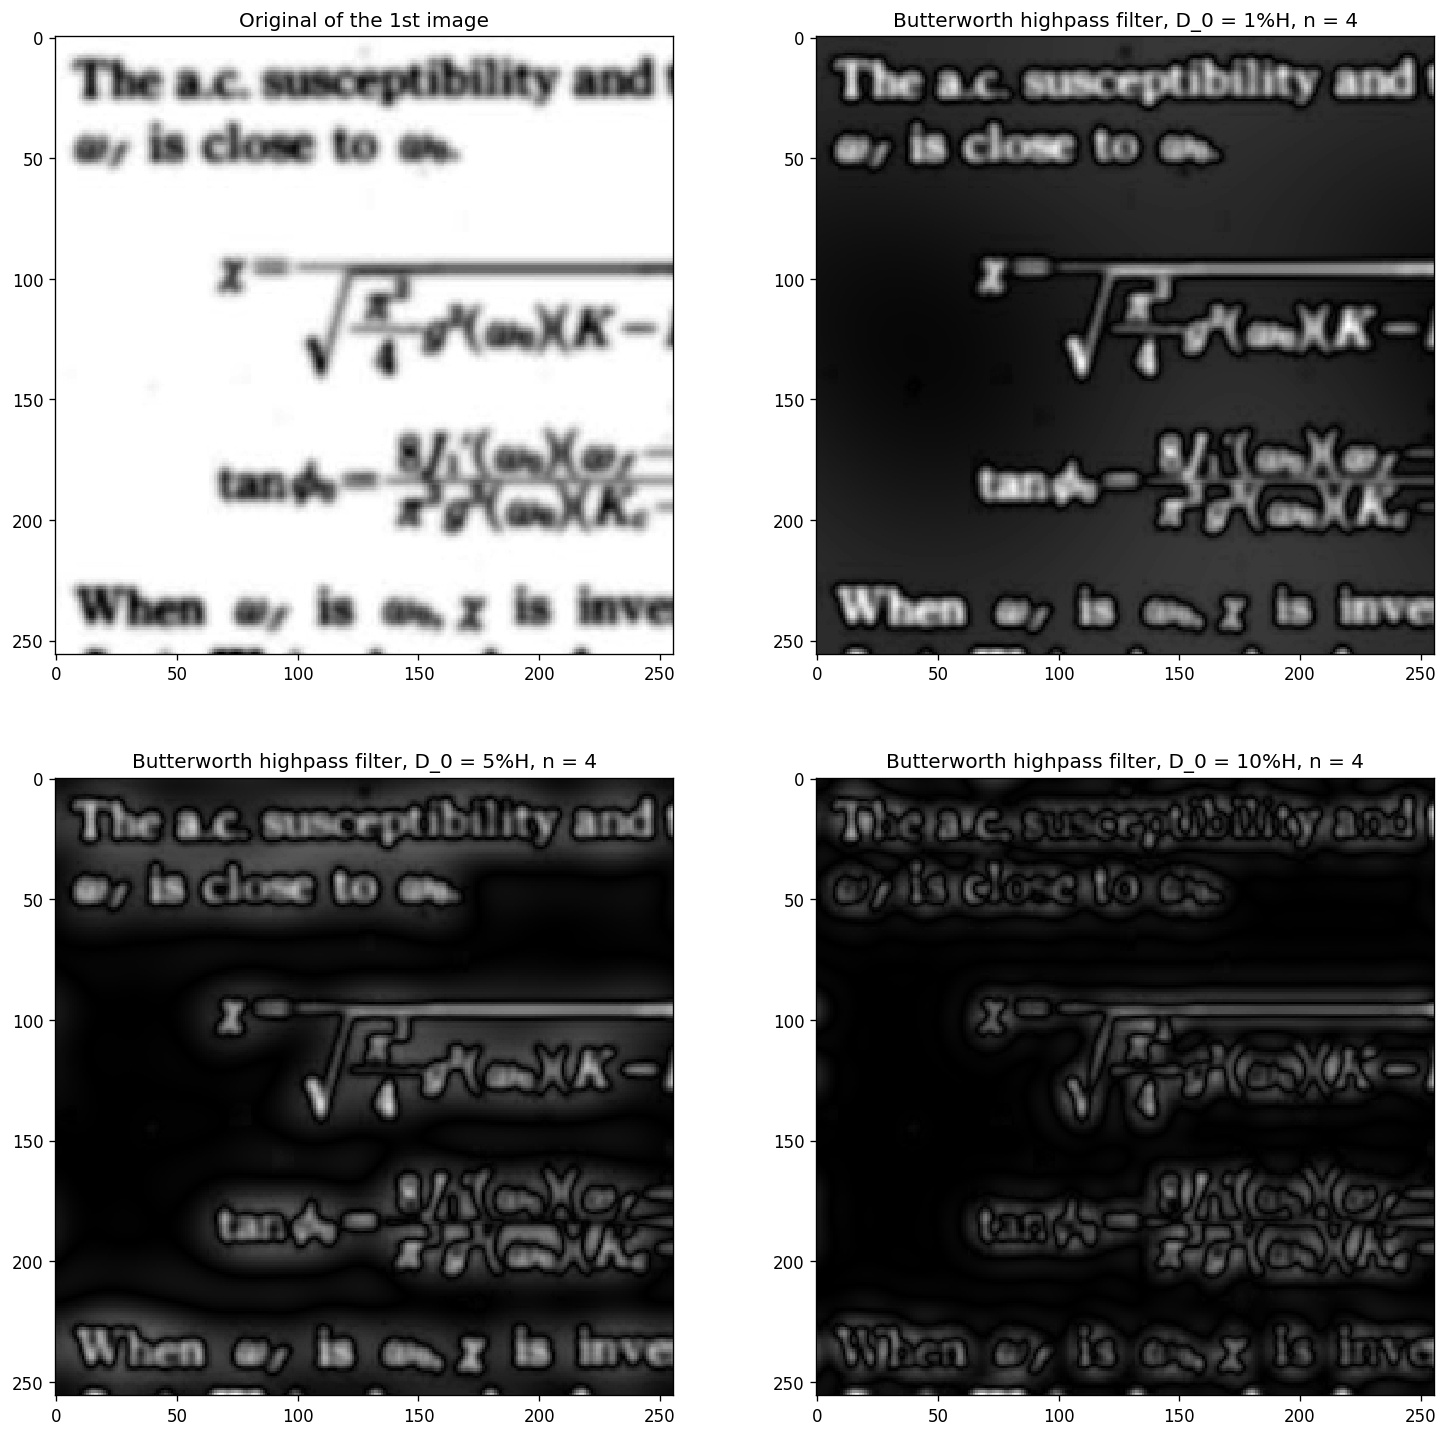

In [37]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15), dpi=120)
axs[0, 0].imshow(np_1_sum, cmap='gray')
axs[0, 0].set_title('Original of the 1st image')
axs[0, 1].imshow(np_1_bw1i_4, cmap='gray')
axs[0, 1].set_title('Butterworth highpass filter, D_0 = 1%H, n = 4')
axs[1, 0].imshow(np_1_bw2i_4, cmap='gray')
axs[1, 0].set_title('Butterworth highpass filter, D_0 = 5%H, n = 4')
axs[1, 1].imshow(np_1_bw3i_4, cmap='gray')
axs[1, 1].set_title('Butterworth highpass filter, D_0 = 10%H, n = 4')
plt.show()

The same can be told concerning this result.

In [69]:
np_1_gs1, np_1_gs1_fm = apply_gauss_HP(np_1_fft, .01)
np_1_gs2, np_1_gs2_fm = apply_gauss_HP(np_1_fft, .05)
np_1_gs3, np_1_gs3_fm = apply_gauss_HP(np_1_fft, .10)

np_1_gs1i = np.abs(get_ifft(np_1_gs1))
np_1_gs2i = np.abs(get_ifft(np_1_gs2))
np_1_gs3i = np.abs(get_ifft(np_1_gs3))

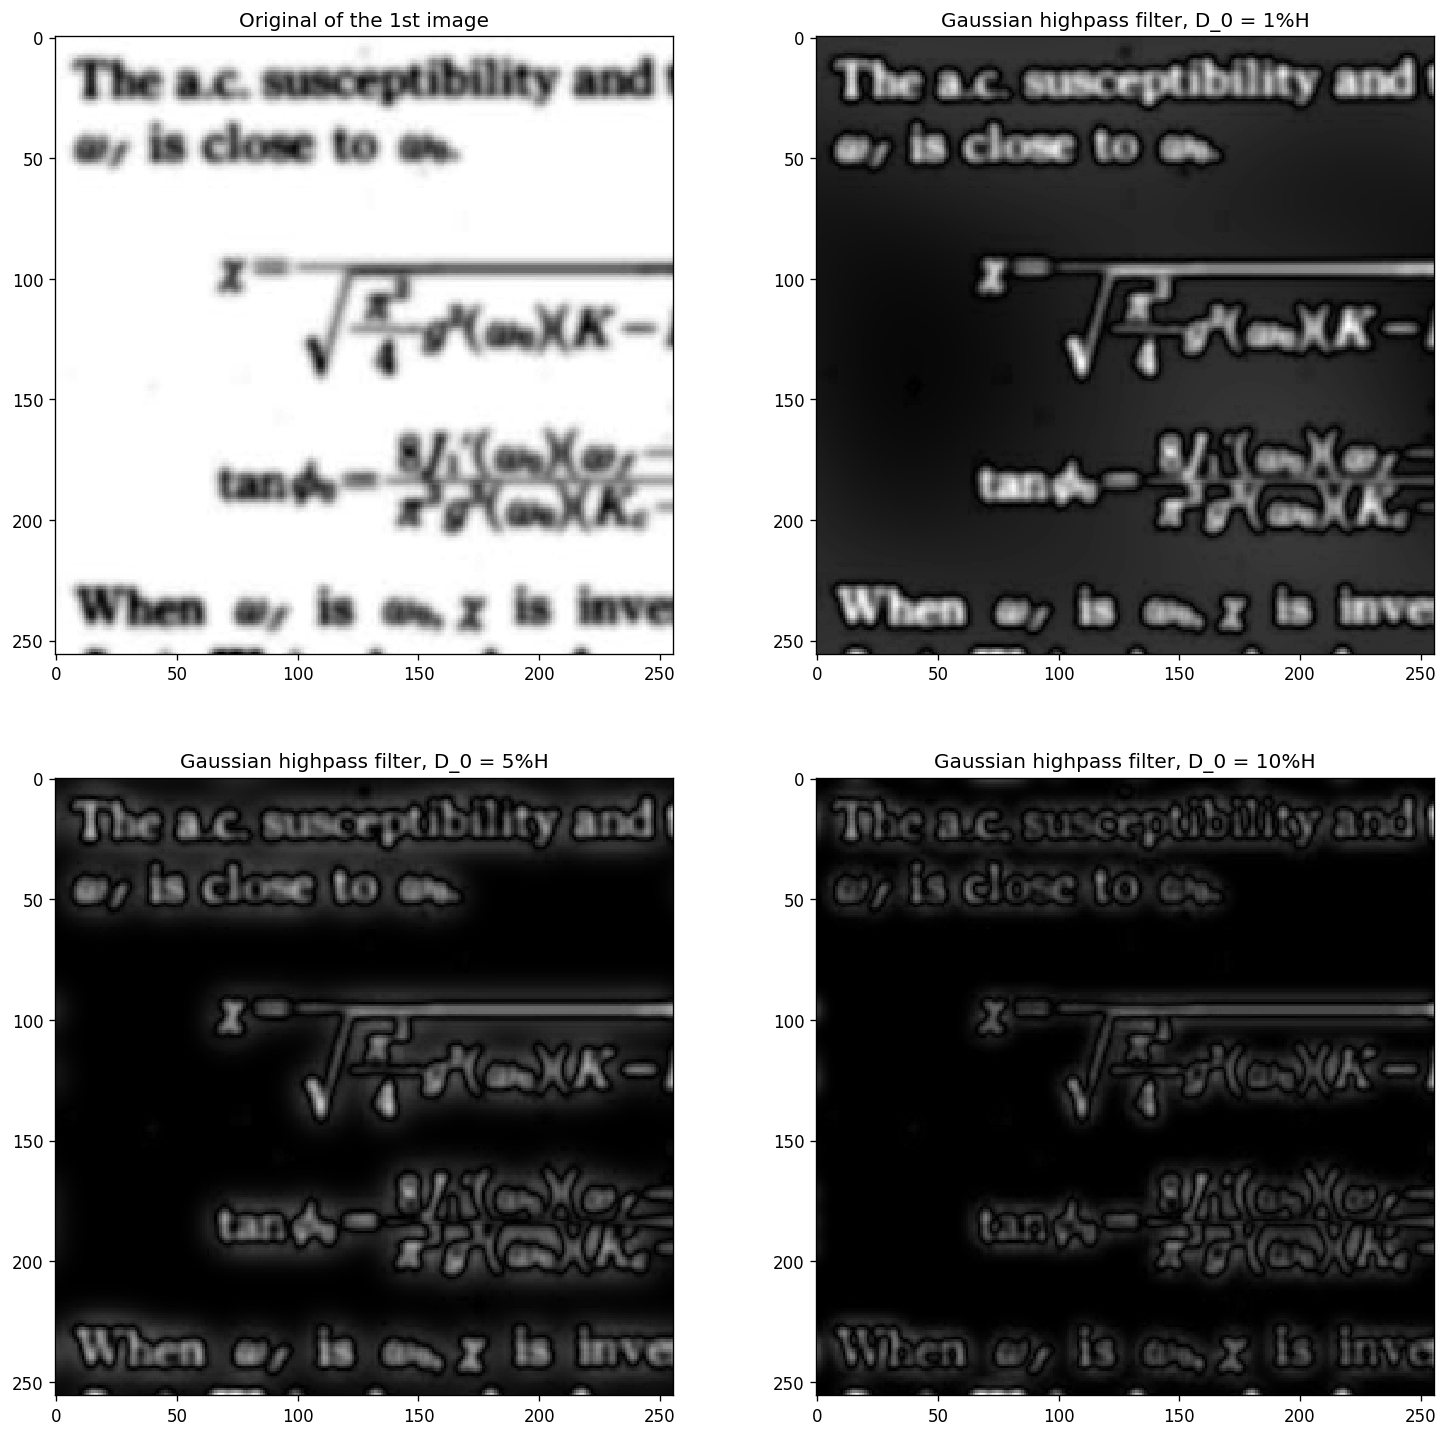

In [62]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15), dpi=120)
axs[0, 0].imshow(np_1_sum, cmap='gray')
axs[0, 0].set_title('Original of the 1st image')
axs[0, 1].imshow(np_1_gs1i, cmap='gray')
axs[0, 1].set_title('Gaussian highpass filter, D_0 = 1%H')
axs[1, 0].imshow(np_1_gs2i, cmap='gray')
axs[1, 0].set_title('Gaussian highpass filter, D_0 = 5%H')
axs[1, 1].imshow(np_1_gs3i, cmap='gray')
axs[1, 1].set_title('Gaussian highpass filter, D_0 = 10%H')
plt.show()

The results at $D_0 \sim 5\%$ and $D_0 \sim 10\%$ are very similar and both are superior.

In [60]:
np_1_ll, _ = apply_laplac_HP(np_1_fft)
np_1_l1i = np.abs(get_ifft(np_1_ll))

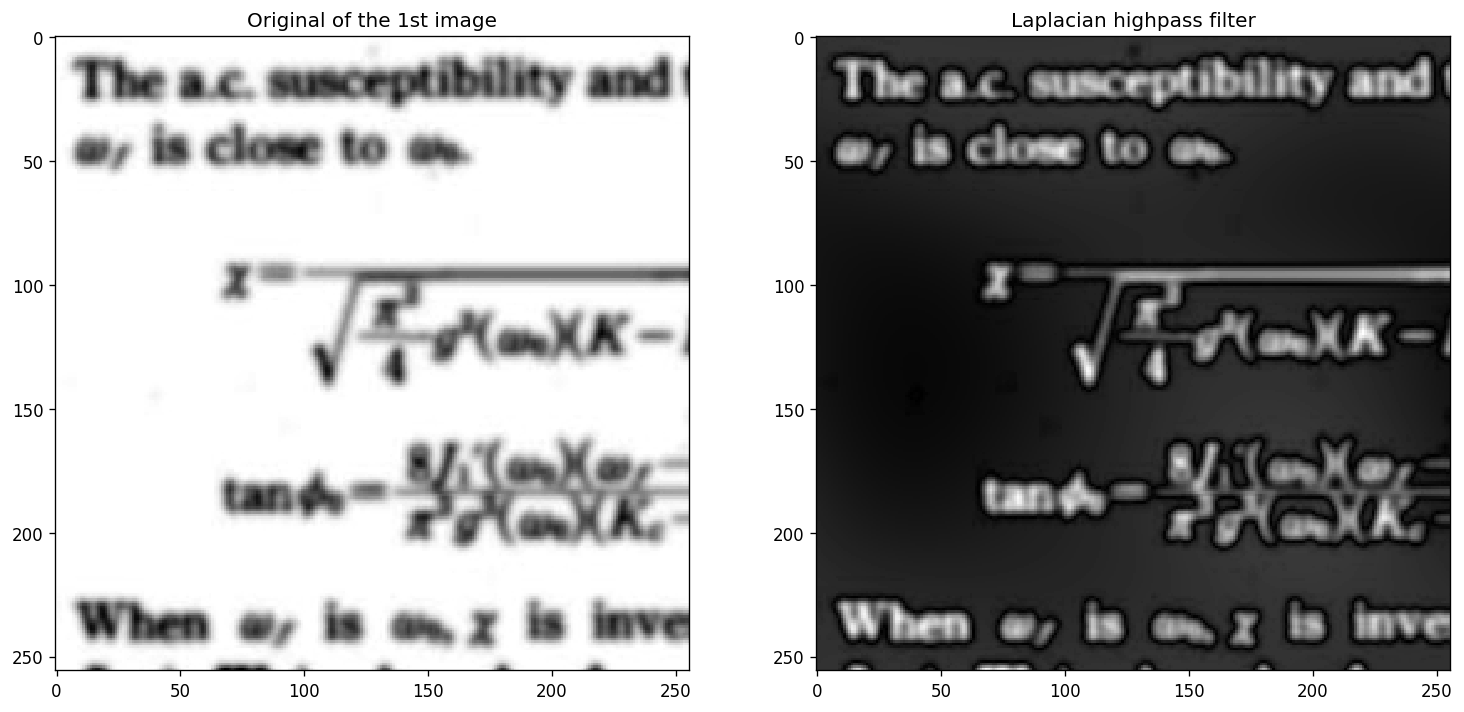

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(15, 15), dpi=120)
axs[0].imshow(np_1_sum, cmap='gray')
axs[0].set_title('Original of the 1st image')
axs[1].imshow(np_1_gs1i, cmap='gray')
axs[1].set_title('Laplacian highpass filter')
plt.show()

The result is very similar to those obtained with other filters at $D_0 \sim 5\%$.

Now we try to process both of the images using the amplification highpass filter with the gaussian $H(u, v)$. 

In [89]:
_, np_2_gs1_fm = apply_gauss_HP(np_2_fft, 0.05)
_, np_2_gs2_fm = apply_gauss_HP(np_2_fft, 0.05)
_, np_2_gs3_fm = apply_gauss_HP(np_2_fft, 0.1)

np_1_hpgs1 = apply_amp_HP(np_1_fft, np_1_gs1_fm, 2, 3)
np_1_hpgs2 = apply_amp_HP(np_1_fft, np_1_gs2_fm, 2, 3)
np_1_hpgs3 = apply_amp_HP(np_1_fft, np_1_gs3_fm, 2, 3)

np_2_hpgs1 = apply_amp_HP(np_2_fft, np_2_gs1_fm, 2, 3)
np_2_hpgs2 = apply_amp_HP(np_2_fft, np_2_gs2_fm, 2, 3)
np_2_hpgs3 = apply_amp_HP(np_2_fft, np_2_gs3_fm, 2, 3)

np_1_hpgs1i = np.abs(get_ifft(np_1_hpgs1))
np_1_hpgs2i = np.abs(get_ifft(np_1_hpgs2))
np_1_hpgs3i = np.abs(get_ifft(np_1_hpgs3))

np_2_hpgs1i = np.abs(get_ifft(np_2_hpgs1))
np_2_hpgs2i = np.abs(get_ifft(np_2_hpgs2))
np_2_hpgs3i = np.abs(get_ifft(np_2_hpgs3))

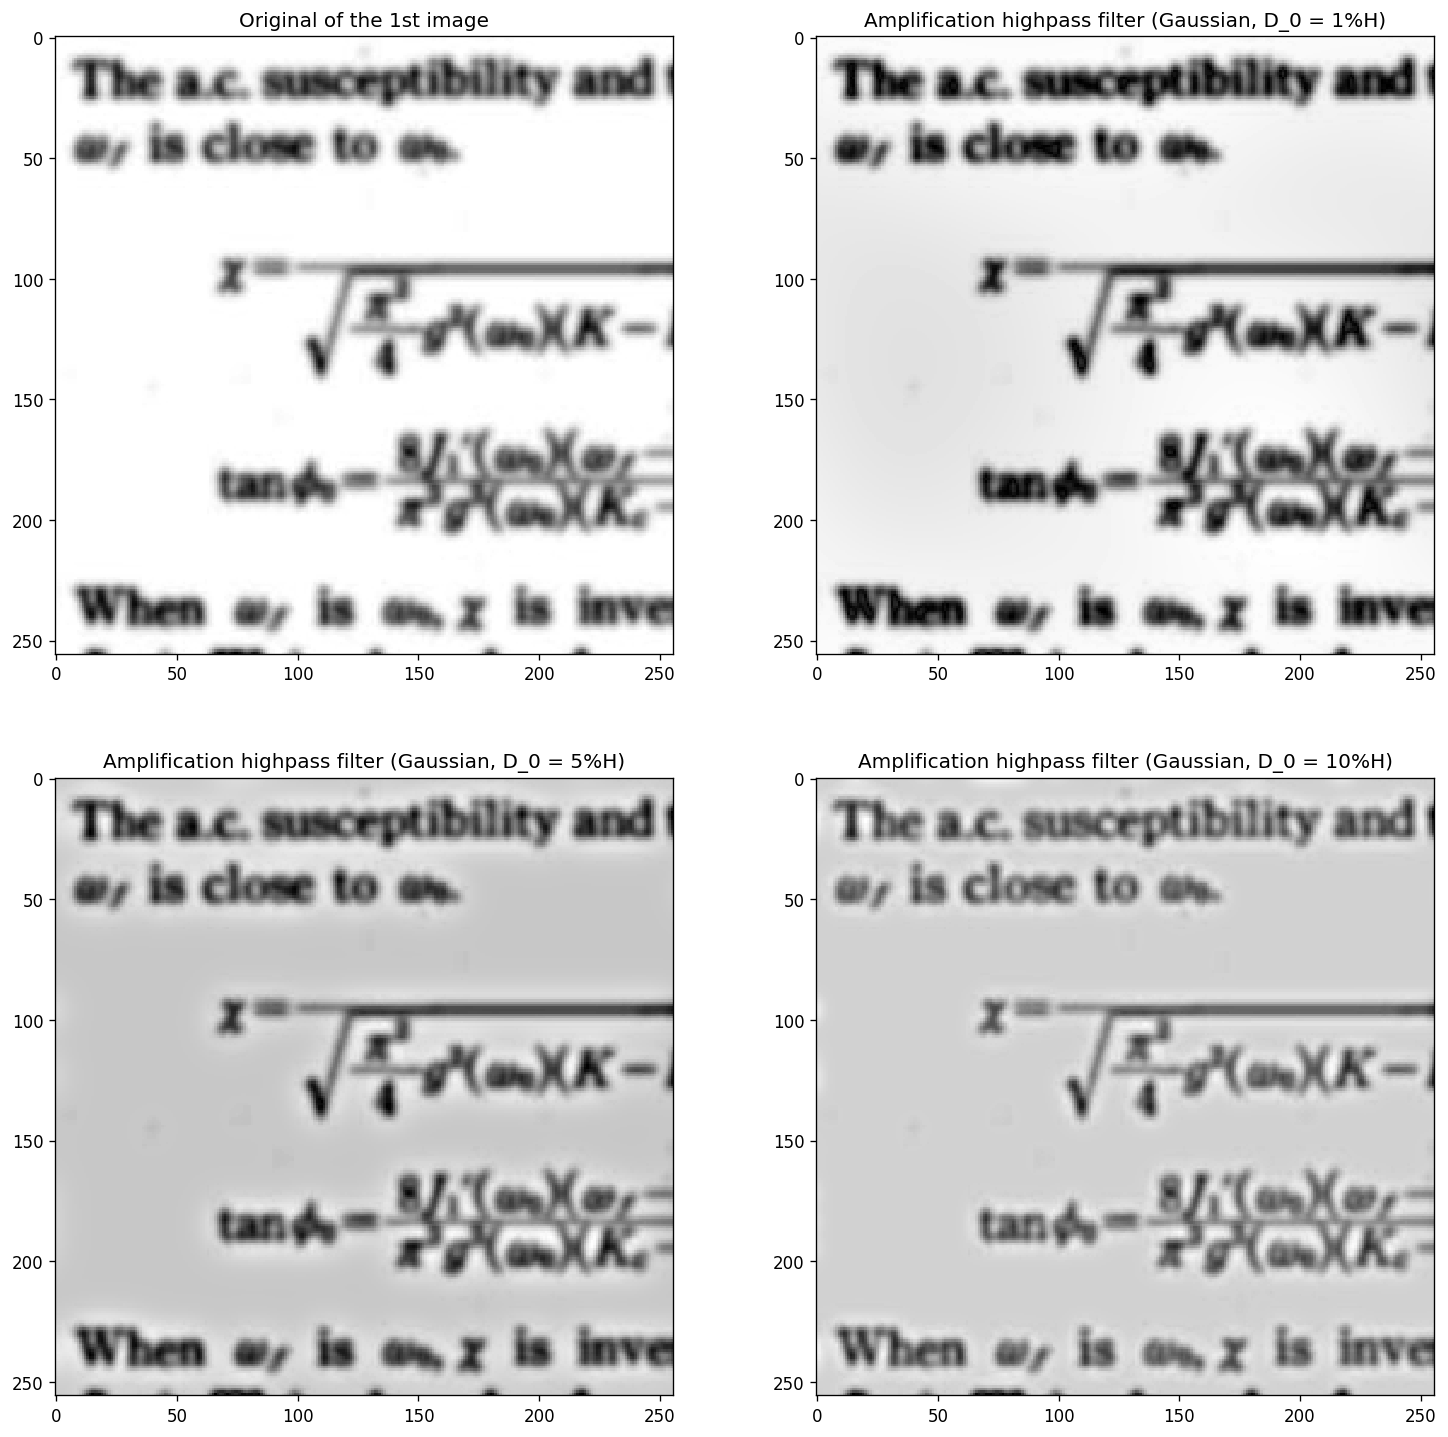

In [90]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15), dpi=120)

axs[0, 0].imshow(np_1_sum, cmap='gray')
axs[0, 0].set_title('Original of the 1st image')
axs[0, 1].imshow(np_1_hpgs1i, cmap='gray')
axs[0, 1].set_title('Amplification highpass filter (Gaussian, D_0 = 1%H)')
axs[1, 0].imshow(np_1_hpgs2i, cmap='gray')
axs[1, 0].set_title('Amplification highpass filter (Gaussian, D_0 = 5%H)')
axs[1, 1].imshow(np_1_hpgs3i, cmap='gray')
axs[1, 1].set_title('Amplification highpass filter (Gaussian, D_0 = 10%H)')
plt.show()

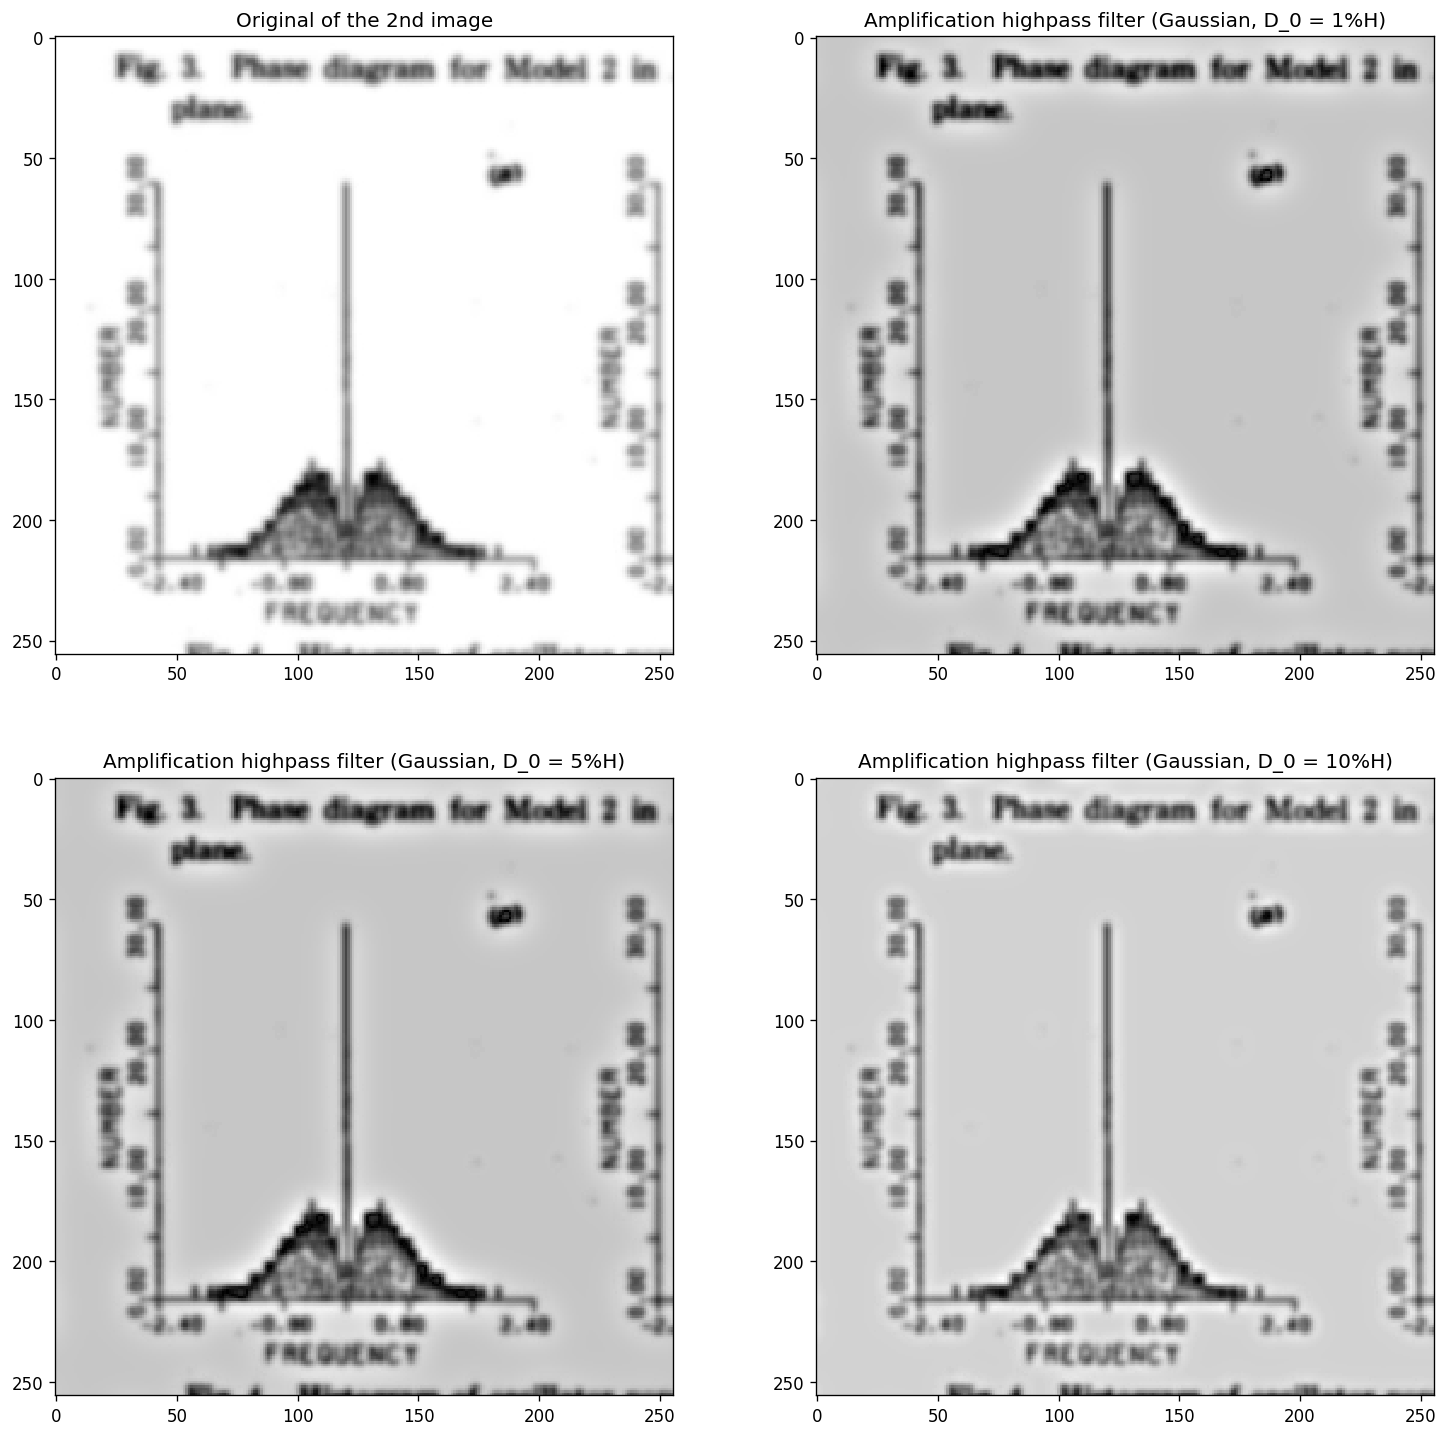

In [91]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15), dpi=120)

axs[0, 0].imshow(np_2_sum, cmap='gray')
axs[0, 0].set_title('Original of the 2nd image')
axs[0, 1].imshow(np_2_hpgs1i, cmap='gray')
axs[0, 1].set_title('Amplification highpass filter (Gaussian, D_0 = 1%H)')
axs[1, 0].imshow(np_2_hpgs2i, cmap='gray')
axs[1, 0].set_title('Amplification highpass filter (Gaussian, D_0 = 5%H)')
axs[1, 1].imshow(np_2_hpgs3i, cmap='gray')
axs[1, 1].set_title('Amplification highpass filter (Gaussian, D_0 = 10%H)')
plt.show()

Application of the amplification filter allowed to make text more readable.